In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as mticker
import requests
import time
import matplotlib.animation as animation
from mpl_finance import candlestick_ohlc

plt.rcParams['image.cmap'] = 'jet'
plt.rcParams['figure.figsize'] = (16, 8)
# recet to matplotlib standards
#jtplot.reset()

# matplotlib overrides
plt.rcParams['savefig.dpi'] = 120
plt.rcParams['figure.autolayout'] = False
plt.rcParams['figure.figsize'] = (16, 8)
plt.rcParams['figure.titlesize'] = 24
plt.rcParams['figure.titleweight'] = 'bold'
plt.rcParams['axes.labelsize'] = 16
plt.rcParams['axes.labelweight'] = 'bold'
plt.rcParams['axes.titlesize'] = 20
plt.rcParams['axes.titleweight'] = 'bold'
plt.rcParams['font.size'] = 16
plt.rcParams['lines.linewidth'] = 2.0
plt.rcParams['lines.markersize'] = 8
plt.rcParams['legend.fontsize'] = 16
plt.rcParams['text.usetex'] = False
#plt.rcParams['font.family'] = "serif"
plt.rcParams['font.serif'] = "cm"
plt.rcParams['text.latex.preamble'] = b"\usepackage{subdepth}, \usepackage{type1cm}"

In [2]:
# get stock information
def get_symbol(symbol):
    url = "http://d.yimg.com/autoc.finance.yahoo.com/autoc?query={}&region=1&lang=en".format(symbol)

    result = requests.get(url).json()

    for x in result['ResultSet']['Result']:
        if x['symbol'] == symbol:
            return x['name']


get_symbol("AMD")

'Advanced Micro Devices, Inc.'

In [3]:
# https://stackoverflow.com/questions/20526414/relative-strength-index-in-python-pandas/23794250#23794250
def compute_rsi(prices, n=14):
    ''' rsi indicator '''
    x = prices.diff(1).fillna(0) # calculate price gain with previous day, first row nan is filled with 0

    def rsi_roll_calc(p):
        # subfunction for calculating rsi for one lookback period
        up = p[p>0].sum() / n
        down = -p[p<0].sum() / n
        rs = up / down
        return 100 - 100 / (1 + rs)

    # run for all periods with rolling_apply
    return x.rolling(n, center=False).apply(rsi_roll_calc)

In [4]:
def compute_sma(prices, window=14):
    pass

In [5]:
# exponentially weighted windows
# http://pandas.pydata.org/pandas-docs/stable/computation.html#exponentially-weighted-windows
# use .ewm().mean() for exponential moving averages
def compute_ema(x, n=12):
    return x.ewm(n).mean()

In [6]:
def compute_macd(x, n_slow=26, n_fast=12):
    """
    Moving Average Convergence / Divergence Osciliator
    macd line = 12 ema - 26 ema
    signal line = 9ema of macd line
    histogram = macd line - signal line
    """
    ema_slow = compute_ema(x, n_slow)
    ema_fast = compute_ema(x, n_fast)
    return ema_slow, ema_fast, ema_fast - ema_slow

In [9]:
df = pd.read_csv('./data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
df.tail(1).index.strftime('%d-%b-%y')[0]

'01-Dec-17'

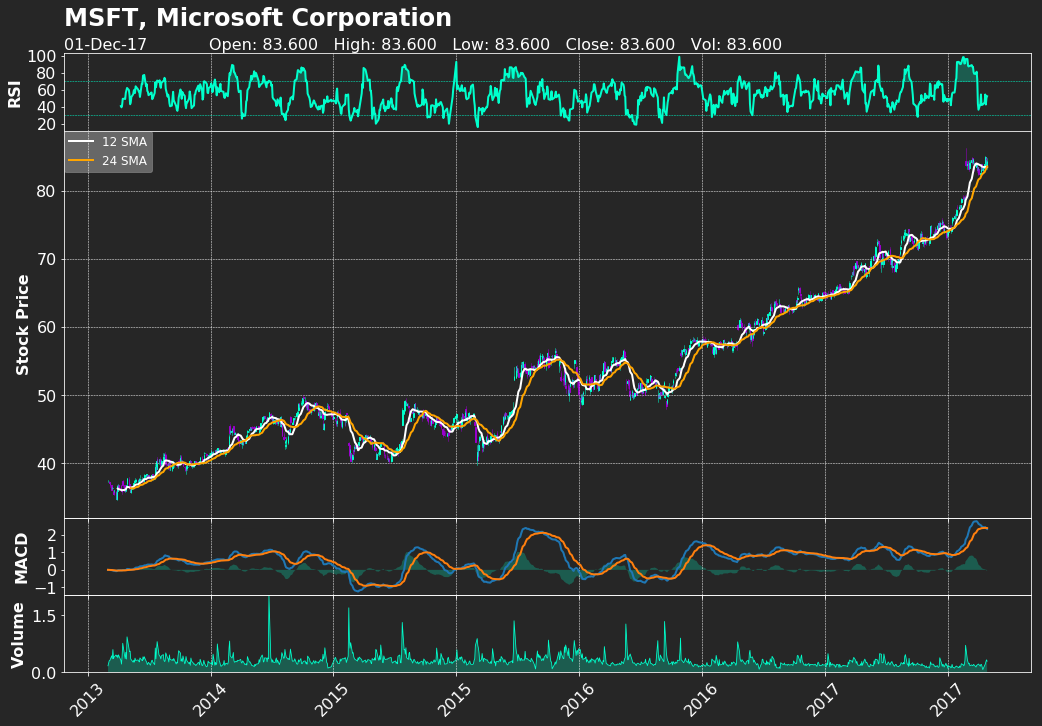

In [8]:
def chart_data(ticker, ma1, ma2):

    df = pd.read_csv('./data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
    
    # calculations
    x=0
    y=len(df.index.date)
    arr = []
    while x<y:
        a = df.index.date[x].toordinal(), df.Open[x], df.High[x], df.Low[x], df.Close[x], df.Volume[x]
        arr.append(a)
        x += 1
    
    # INITIALIZE FIGURE
    fig = plt.figure(figsize=(16,10), facecolor='#262626')
    
    # AX4 VOLUME PLOT
    ax4 = plt.subplot2grid((8, 4), (7, 0), rowspan=1, colspan=4, facecolor='#262626')
    ax4.plot(df.index.date, df.Volume, color='#00ffcc', linewidth=.8)
    ax4.fill_between(df.index.date, 0, df.Volume, facecolor='#00ffcc', alpha=.25)
    ax4.yaxis.set_major_locator(mticker.MaxNLocator(2, prune='upper'))
    ax4.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
    ax4.spines['bottom'].set_color('w')
    ax4.spines['top'].set_color('w')
    ax4.spines['left'].set_color('w')
    ax4.spines['right'].set_color('w')
    #ax4.set_ylim(0, 6*df.Volume.max())
    ax4.tick_params(axis='both', colors='w')
    ax4.margins(y=0, tight=True)
    plt.ylabel('Volume', color='w')
        # label rotation
    for label in ax4.xaxis.get_ticklabels():
        label.set_rotation(45)
    # plt.xlabel('Date')
    
    
    # AX3 MACD PLOT
    ax3 = plt.subplot2grid((8,4), (6, 0), sharex=ax4, rowspan=1, colspan=4, facecolor='#262626')
    #ax3.plot(df.index.date, df.Volume, color='#00ffcc', linewidth=.8)
    #ax3.fill_between(df.index.date, 0, df.Volume, facecolor='#00ffcc', alpha=.25)
    n_slow = 26
    n_fast = 12
    n_ema = 9
    ema_slow, ema_fast, macd = compute_macd(df.Close, n_slow, n_fast)
    ema9 = compute_ema(macd, n_ema)
    ax3.plot(df.index.date, macd)
    ax3.plot(df.index.date, ema9)
    ax3.fill_between(df.index.date, macd-ema9, facecolor='#00ffcc', alpha=.25)
    ax3.yaxis.set_major_locator(mticker.MaxNLocator(5, prune='upper'))
    ax3.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
    ax3.spines['bottom'].set_color('w')
    ax3.spines['top'].set_color('w')
    ax3.spines['left'].set_color('w')
    ax3.spines['right'].set_color('w')
    ax3.tick_params(axis='both', colors='w')
    ax3.yaxis.label.set_color('w')
    ax3.xaxis.label.set_color('w')
    ax3.axes.xaxis.set_visible(True)
    plt.setp(ax3.get_xticklabels(), visible=False)
    
    plt.ylabel('MACD')

    
    
    # AX1 RSI PLOT  
    ax1 = plt.subplot2grid((8, 4), (0, 0), sharex=ax4, rowspan=1, colspan=4, facecolor='#262626')
    rsi = compute_rsi(df.Close)
    ax1.plot(df.index.date, rsi, color='#00ffcc')
    ax1.axhline(70, color='#00ffcc', linewidth=.5, linestyle='--')
    ax1.axhline(30, color='#00ffcc', linewidth=.5, linestyle='--')
    ax1.fill_between(df.index.date, rsi, 70, where=(rsi>=70), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
    ax1.fill_between(df.index.date, rsi, 30, where=(rsi<=30), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
    ax1.xaxis.grid(True, color='white', linewidth=.5, linestyle='--')
    ax1.spines['bottom'].set_color('w')
    ax1.spines['top'].set_color('w')
    ax1.spines['left'].set_color('w')
    ax1.spines['right'].set_color('w')
    ax1.tick_params(axis='both', colors='w')
    ax1.yaxis.label.set_color('w')
    plt.setp(ax1.get_xticklabels(), visible=False)
    ax1.yaxis.set_major_locator(mticker.MaxNLocator(5))
    plt.ylabel('RSI', color='w')
    
    
    # AX2 CANDLESTICK PLOT WITH VOLUME OVERLAY
    ax2 = plt.subplot2grid((8, 4), (1, 0), sharex=ax4, rowspan=5, colspan=4, facecolor='#262626')
    candlestick_ohlc(ax2, arr, width=1, colorup='#00ffcc', colordown='#9900cc')
    ax2.grid(True, color='white', linewidth=.5, linestyle='--')
    ax2.xaxis.set_major_locator(mticker.MaxNLocator(10, prune='upper'))
    ax2.spines['bottom'].set_color('w')
    ax2.spines['top'].set_color('w')
    ax2.spines['left'].set_color('w')
    ax2.spines['right'].set_color('w')
    ax2.tick_params(axis='both', colors='w')
    ax2.yaxis.label.set_color('w')
    ax2.axes.xaxis.set_visible(True)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('Stock Price')
    
    #plot averages
    ax2.plot(df.index.date, df.Close.rolling(window=ma1).mean(), label='12 SMA', color='w')
    ax2.plot(df.index.date, df.Close.rolling(window=ma2).mean(), label='24 SMA', color='orange')
    legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
    legend.get_frame().set_alpha(0.3)
    legend_text = plt.gca().get_legend().get_texts()
    plt.setp(legend_text[0:5], color='w')

    
    # FIGURE TITLE AND FORMATTING OVERALL
    #plt.suptitle('{ticker}'.format(ticker=ticker), color='w', horizontalalignment='left')
    ax1.text(0, 1.6, '{ticker}, {info}'.format(ticker=ticker, info=get_symbol(ticker)), 
             horizontalalignment='left', verticalalignment='top', color='w', fontsize=24, fontweight='bold', transform=ax1.transAxes)
    ax1.text(0, 1.2, '{}'.format(df.tail(1).index.strftime('%d-%b-%y')[0]), 
             horizontalalignment='left', verticalalignment='top', color='w', transform=ax1.transAxes)
    ax1.text(0.15, 1.2, 'Open: {0:.3f}   High: {0:.3f}   Low: {0:.3f}   Close: {0:.3f}   Vol: {0:.3f}'.format(df.Open[-1], 
                                                                                                              df.High[-1], 
                                                                                                              df.Low[-1], 
                                                                                                              df.Close[-1],
                                                                                                              df.Volume[-1]), 
             horizontalalignment='left', verticalalignment='top', color='w', transform=ax1.transAxes)
    plt.subplots_adjust(left=0.1, bottom=0.09, right=0.94, top=0.95, wspace=0.20, hspace=0)
    
    #plt.savefig('example.png', facecolor=fig.get_facecolor())
    plt.show()
  

ticker = 'MSFT'
chart_data(ticker, 12, 26)


In [25]:
def animate(i):
    plot_data(ticker, 12, 26)

In [160]:
ani = animation.FuncAnimation(fig, animate, interval=5000)

NameError: name 'fig' is not defined

## Older implementations

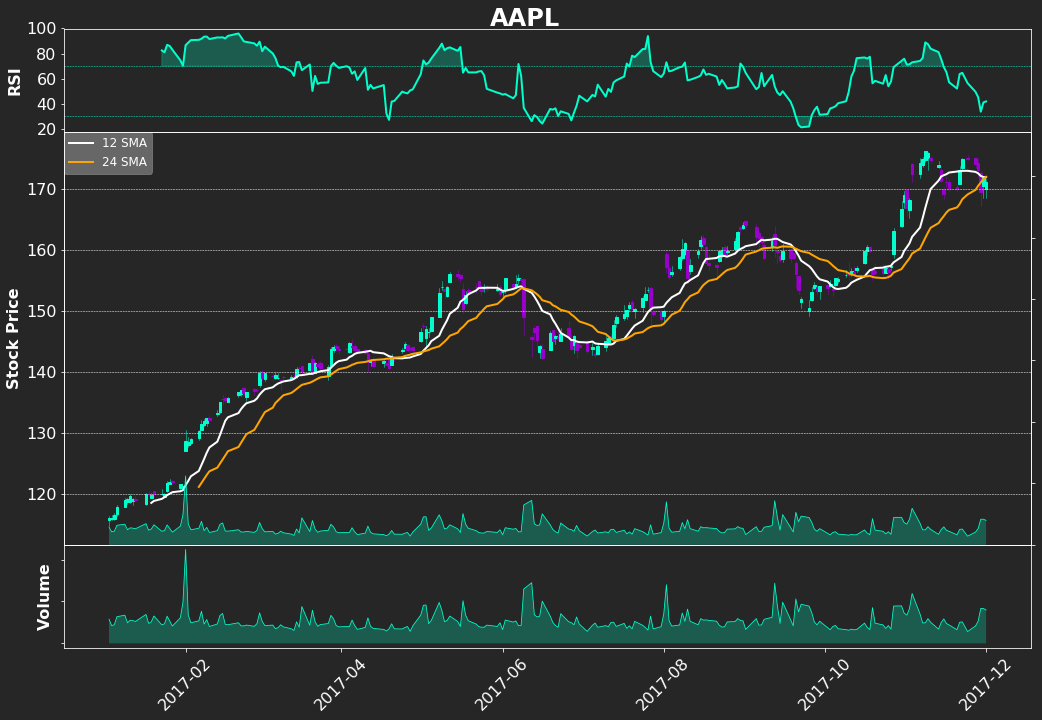

In [10]:
def plot_data_old(ticker, ma1, ma2):

    df = pd.read_csv('./data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
    
    # calculations
    x=0
    y=len(df.index.date)
    arr = []
    while x<y:
        a = df.index.date[x].toordinal(), df.Open[x], df.High[x], df.Low[x], df.Close[x], df.Volume[x]
        arr.append(a)
        x += 1
        
    fig = plt.figure(figsize=(16,10), facecolor='#262626')
    
    # volume overlay https://www.youtube.com/watch?v=SYvjaL2pWZw
    # volume plot ax3
    ax3 = plt.subplot2grid((6,4), (5, 0), rowspan=1, colspan=4, facecolor='#262626')
    ax3.plot(df.index.date, df.Volume, color='#00ffcc', linewidth=.8)
    ax3.fill_between(df.index.date, 0, df.Volume, facecolor='#00ffcc', alpha=.25)
    ax3.axes.yaxis.set_ticklabels([])
    ax3.grid(False)
    ax3.spines['bottom'].set_color('w')
    ax3.spines['top'].set_color('w')
    ax3.spines['left'].set_color('w')
    ax3.spines['right'].set_color('w')
    ax3.tick_params(axis='both', colors='w')
    ax3.yaxis.label.set_color('w')
    ax3.xaxis.label.set_color('w')
    plt.ylabel('Volume')
    # labeling and axes styling
    for label in ax3.xaxis.get_ticklabels():
        label.set_rotation(45)
    # plt.xlabel('Date')
    

    
    # RSI plot    
    ax1 = plt.subplot2grid((6, 4), (0, 0), sharex=ax3, rowspan=1, colspan=4, facecolor='#262626')
    rsi = calculate_rsi(df.Close)
    ax1.plot(df.index.date, rsi, color='#00ffcc')
    #ax1.set_ylim(0, 100)
    ax1.axhline(70, color='#00ffcc', linewidth=.5, linestyle='--')
    ax1.axhline(30, color='#00ffcc', linewidth=.5, linestyle='--')
    ax1.fill_between(df.index.date, rsi, 70, where=(rsi>=70), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
    ax1.fill_between(df.index.date, rsi, 30, where=(rsi<=30), facecolor='#00ffcc', edgecolor='#00ffcc', alpha=.25)
    #ax1.grid(True, color='white', linewidth=.5, linestyle='--')
    ax1.spines['bottom'].set_color('w')
    ax1.spines['top'].set_color('w')
    ax1.spines['left'].set_color('w')
    ax1.spines['right'].set_color('w')
    ax1.tick_params(axis='both', colors='w')
    ax1.yaxis.label.set_color('w')
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.gca().yaxis.set_major_locator(mticker.MaxNLocator(5))
    plt.ylabel('RSI', color='w')
    
    
    # candlestick plot ax1 with volume overlay
    ax2 = plt.subplot2grid((6, 4), (1, 0), sharex=ax3, rowspan=4, colspan=4, facecolor='#262626')
    candlestick_ohlc(ax2, arr, width=1, colorup='#00ffcc', colordown='#9900cc')
    ax2.grid(True, color='white', linewidth=.5, linestyle='--')
    ax2.xaxis.set_major_locator(mticker.MaxNLocator(10))
    ax2.spines['bottom'].set_color('w')
    ax2.spines['top'].set_color('w')
    ax2.spines['left'].set_color('w')
    ax2.spines['right'].set_color('w')
    ax2.tick_params(axis='both', colors='w')
    ax2.yaxis.label.set_color('w')
    ax2.axes.xaxis.set_visible(False)
    plt.setp(ax2.get_xticklabels(), visible=False)
    plt.ylabel('Stock Price')
    
    #plot averages
    ax2.plot(df.index.date, df.Close.rolling(window=ma1).mean(), label='12 SMA', color='w')
    ax2.plot(df.index.date, df.Close.rolling(window=ma2).mean(), label='24 SMA', color='orange')
    legend = plt.legend(loc=2, prop={'size': 12}, fancybox=True, borderaxespad=0.)
    legend.get_frame().set_alpha(0.3)
    legend_text = plt.gca().get_legend().get_texts()
    plt.setp(legend_text[0:5], color='w')

    # ax2 volume overlay
    ax2o = ax2.twinx()
    ax2o.plot(df.index.date, df.Volume, color='#00ffcc', linewidth=.8)
    ax2o.fill_between(df.index.date, 0, df.Volume, facecolor='#00ffcc', alpha=.25)
    ax2o.axes.yaxis.set_ticklabels([])
    ax2o.grid(False)
    ax2o.spines['bottom'].set_color('w')
    ax2o.spines['top'].set_color('w')
    ax2o.spines['left'].set_color('w')
    ax2o.spines['right'].set_color('w')
    ax2o.set_ylim(0, 6*df.Volume.max())
    ax2o.tick_params(axis='both', colors='w')

    
    plt.suptitle('{ticker}'.format(ticker=ticker), color='w')
    plt.subplots_adjust(left=0.1, bottom=0.09, right=0.94, top=0.95, wspace=0.20, hspace=0)
    
    plt.savefig('example.png', facecolor=fig.get_facecolor())
    plt.show()
  

ticker = 'AAPL'
plot_data_old(ticker, 12, 24)

In [ ]:
def plot_data3(ticker):

    df = pd.read_csv('./data/{ticker}.csv'.format(ticker=ticker), sep=';', parse_dates=True, header=0, index_col=0)
    
    fig = plt.figure(figsize=(16,10))
    ax1 = plt.subplot2grid((4, 4), (0, 0), rowspan=3, colspan=4)
    
    ax1.plot(df.index.date, df.Open)
    ax1.plot(df.index.date, df.High)
    ax1.plot(df.index.date, df.Low)
    ax1.plot(df.index.date, df.Close)
    
    ax1.grid(True)
    ax1.xaxis.set_major_locator(mticker.MaxNLocator(10))
    plt.ylabel('Stock Price')
    
    ax2 = plt.subplot2grid((4,4), (3, 0), sharex=ax1, rowspan=1, colspan=4)
    ax2.bar(df.index.date, df.Volume)
    ax2.axes.yaxis.set_ticklabels([])
    ax2.grid(True)
    plt.ylabel('Volume')
    for label in ax2.xaxis.get_ticklabels():
        label.set_rotation(45)

    
    
    plt.xlabel('Date')
    plt.suptitle('{ticker} Stock Price'.format(ticker=ticker))
    
    ax1.axes.xaxis.set_visible(False)
    plt.setp(ax1.get_xticklabels(), visible=False)
    plt.subplots_adjust(left=0.1, bottom=0.09, right=0.94, top=0.94, wspace=0.20, hspace=0.2)
    plt.savefig('example.png')
    plt.show()



ticker = 'AAPL'
plot_data3(ticker)

In [ ]:
def cal_rsi(prices, n=14):
    """
    Calculate the RSI of a given price
    """
    deltas = np.diff(prices)
    seed = deltas[:n+1]
    up = seed[seed>0].sum() / n
    down = -seed[seed<0].sum() / n
    rs = up / down
    rsi = np.zeros_like(prices)
    rsi[:n] = 100. - 100. / (1 + rs)
    
    for i in range(n, len(prices)):
        delta = deltas[i-1]
        if delta > 0:
            upval = delta 
            downval = 0.
        else:
            upval = 0.
            downval = -delta
        
        up = (up * (n-1) + upval) / n
        down = (down * (n-1) + downval) / n
        
        rs = up /down
        rsi[i] = 100. - 100. / (1. + rs)
        
    return rsi
                  